# Part 2: Characterizing population-specific TR variation

This notebook generates the items listed below. For preprocessing see:
* `../size-stats/readme.sh`: summarizes allele frequency info across loci
* `../het-stats/readme.sh`: computes per-locus, per-population, heterozygosity/num allele stats

Figures:
* Figure 2 panels a-f

Supplementary Figures:
* Supp Figure 9: Nalleles vs. heterozygosity

Statistics:
* % of TRs that have het at or nearly 0
* % of TRs that are bi-allelic or have 3+ common alleles

In [1]:
####### Set up #########
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import os
import pandas as pd
import seaborn as sns

PLOTDIR = "pdfs"

def GetSuperpopColors(spop):
    if "EUR" in spop: return "blue"
    if "AFR" in spop: return "gold"
    if "AMR" in spop: return "red"
    if "EAS" in spop: return "green"
    if "SAS" in spop: return "purple"
    if "H3" in spop: return "gray"

Populating the interactive namespace from numpy and matplotlib


# Figure 2a-b: distribution of diff from ref

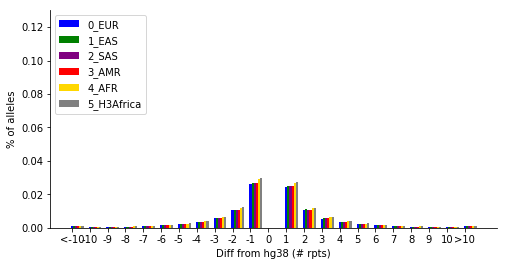

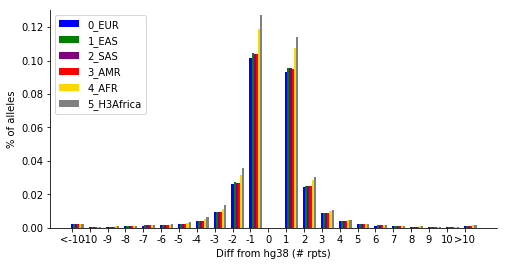

In [22]:
# Load data, sum across all chromosomes
# data gives counts of allele sizes in each sample,
# separately for homopolymers/non-homopolymers
dfs = []
sizecols = list(range(-11, 12))
for chrom in range(1, 22):
    data = pd.read_csv("../size-stats/asize_summary_chr%s.tab"%chrom, sep="\t", 
                  names=["sample","spop","pop","type"] + sizecols)
    dfs.append(data)
data = pd.concat(dfs)

# Aggregate by summarizing across samples/chromosomes
aggdict = {}
for i in sizecols: aggdict[i] = np.sum
data = data.groupby(["spop","type"], as_index=False).agg(aggdict)

w = 0.12
for vtype in ["other","hom"]:
    byspop = data[data["type"]==vtype].copy()
    byspop.index = byspop["spop"]
    byspop = byspop.drop(["spop","type"], 1)
    byspop = byspop.div(byspop.sum(axis=1), axis=0)
    byspop[0] = np.nan

    fig = plt.figure()
    fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    i = 0
    for spop in sorted(list(byspop.index)):
        vals = byspop.loc[spop]
        color = GetSuperpopColors(spop)
        ax.bar([item+w*i for item in sizecols], vals, color=color, label=spop, width=w)
        i += 1
    ax.legend(loc="upper left")
    ax.set_xticks(sizecols)
    ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
    ax.set_xlabel("Diff from hg38 (# rpts)")
    ax.set_ylabel("% of alleles")
    ax.set_ylim(bottom=0, top=0.13)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if vtype == "other":
        figname = "Figure2a-DiffFromRef-Nonhomopolymer.pdf"
    else:
        figname = "Figure2b-DiffFromRef-Homopolymer.pdf"
    fig.savefig(os.path.join(PLOTDIR, figname))

# Figure c: diff from ref vs. allele freq

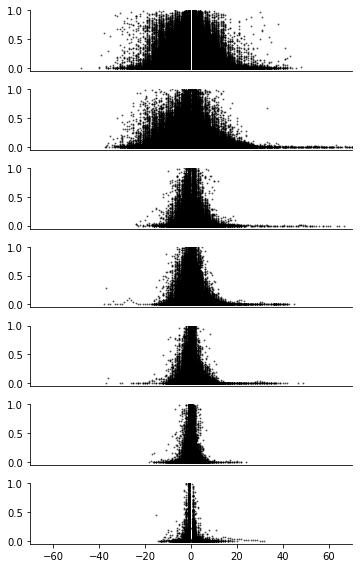

In [25]:
diffs = pd.read_csv("../size-stats/diff_afreqs.tab", sep="\t", names=["chrom","start","period","diff","freq"])

fig = plt.figure()
fig.set_size_inches((5, 8))
for period in range(1, 8):
    if period <= 6:
        xx = diffs[(diffs["period"]==period) & (diffs["diff"].apply(abs) >= 0)]
    else:
        xx = diffs[(diffs["period"]>=period) & (diffs["diff"].apply(abs) >= 0)]
    ax = fig.add_subplot(7, 1, period)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.scatter(xx["diff"], xx["freq"], color="black", s=1, alpha=0.5)
    ax.set_xlim(left=-70, right=70)
    ax.set_ylim(bottom=-0.05, top=1)
    if period != 7: ax.set_xticks([])
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, "Figure2c-DiffVsAfreq.png"))

In [35]:
# Determine position of boxes around NEXN, CA10, CDON repeats

# diffs[(diffs["diff"]>= 10) & (diffs["period"]>6)] # CDON chr11:126065034, box around 10-32
# diffs[(diffs["diff"]>= 10) & (diffs["period"]==3) & (diffs["start"]==77887912 )] # NEXN, box around 10-75
# diffs[(diffs["diff"]>= 10) & (diffs["period"]==3) & (diffs["start"]==51831667 )] # CA10, box around 10-58

# Figure d-f: example allele freq distributions

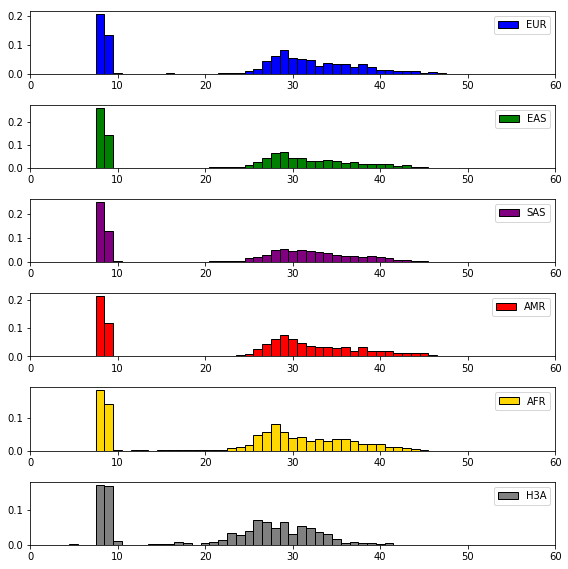

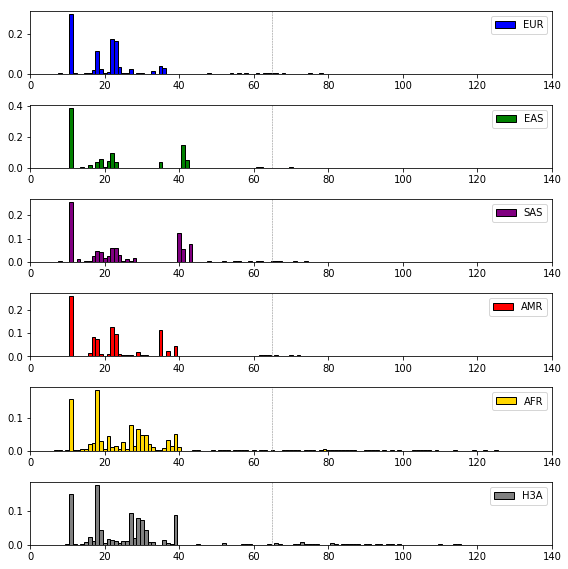

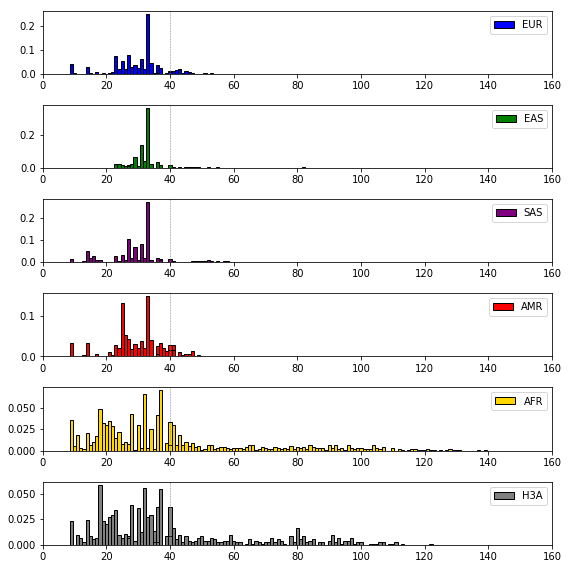

In [47]:
for (chrom, pos, name, maxval, expthresh) in [("chr11", 126065034, "CDON", 60, None), \
                           ("chr17", 51831667, "CA10", 140, 65), \
                          ("chr1", 77887912, "NEXN", 160, 40)]:
    # Run statstr
    cmd = """
    mkdir -p tmp/
    statSTR \
    --vcf /gymreklab-tscc/helia/ensembl/ensemble_out/ensemble_%s_filtered.vcf.gz \
    --vcftype hipstr \
    --afreq --use-length \
    --region %s:%s-%s \
    --samples ../het-stats/EUR_samples.txt,../het-stats/EAS_samples.txt,../het-stats/SAS_samples.txt,../het-stats/AMR_samples.txt,../het-stats/AFR_samples.txt,../het-stats/h3africa_samples.txt \
    --sample-prefixes EUR,EAS,SAS,AMR,AFR,H3A \
    --out tmp/%s.%s.stats
    """%(chrom, chrom, pos, pos, chrom, pos)
    os.system(cmd)
    
    # Load data
    data = pd.read_csv(os.path.join("tmp", "%s.%s.stats.tab")%(chrom, pos), sep="\t")
    if data.shape[0] != 1:
        assert("Need to find exactly one locus!")

    fig = plt.figure()
    fig.set_size_inches((8, 8))
    popnum = 0
    w = 0.15
    for spop in ["EUR","EAS","SAS","AMR","AFR","H3A"]:
        ax = fig.add_subplot(6, 1, popnum+1)
        vals = data["afreq-%s"%spop].values[0]
        xvals = []
        yvals = []
        for ainfo in vals.split(","):
            allele, freq = ainfo.split(":")
            allele = int(float(allele))
            freq = float(freq)
            xvals.append(allele)
            yvals.append(freq)
        ax.bar(xvals, yvals, color=GetSuperpopColors(spop), edgecolor="black", label=spop, width=1)
        if expthresh is not None:
            ax.axvline(x=expthresh, linewidth=0.5, color="gray", linestyle="dashed")
        ax.legend(loc="upper right")
        popnum += 1
        ax.set_xlim(left=0, right=maxval)
    if name == "CDON":
        figname = "Figure2d-AFreq-CDON.pdf"
    if name == "CA10":
        figname = "Figure2e-AFreq-CA10.pdf"
    if name == "NEXN":
        figname = "Figure2f-AFreq-NEXN.pdf"
    fig.savefig(os.path.join(PLOTDIR, figname))
    fig.tight_layout()

# Supp Figure: het vs. num alleles

In [2]:
dfs = []
for chrom in range(1, 23):
    if not os.path.exists("../het-stats/chr%s.period.tab"%chrom): continue
    data = pd.read_csv("../het-stats/chr%s.stats.tab"%chrom, sep="\t")
    perdata = pd.read_csv("../het-stats/chr%s.period.tab"%chrom, sep="\t", names=["chrom","start","period"])
    data = pd.merge(data, perdata, on=["chrom","start"])
    dfs.append(data)
data = pd.concat(dfs)
data_other = data[data["period"] != 1]
data_hom = data[data["period"] == 1]

##### hom #####
Number fixed or nearly fixed (het<0.001): 0.04
Bi-allelic: 0.29
3+alleles: 0.44
##### other #####
Number fixed or nearly fixed (het<0.001): 0.47
Bi-allelic: 0.13
3+alleles: 0.16


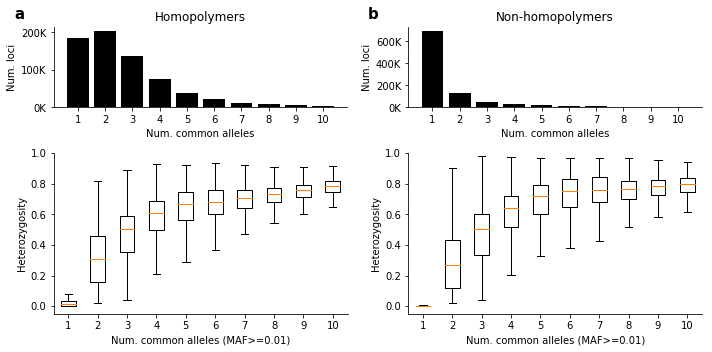

In [48]:
from matplotlib.gridspec import GridSpec

def GetThousandsLabel(yval):
    return "%.0fK"%(yval/1000)

MAX_N = 10

fig = plt.figure()
fig.set_size_inches((10, 5))
gs = GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,2])

for (prefix, df, ax1, ax2) in [("hom", data_hom, fig.add_subplot(gs[0]), fig.add_subplot(gs[2])), 
                               ("other", data_other, fig.add_subplot(gs[1]), fig.add_subplot(gs[3]))]:
    # Plot counts of num alleles
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.bar(range(1, MAX_N+1), [df[df["nalleles-ALL"]==n].shape[0] for n in range(1, MAX_N+1)],
          color="black");
    ax1.set_xticks(range(1,MAX_N+1))
    ax1.set_xticklabels(range(1,MAX_N+1));
    ax1.set_yticklabels([GetThousandsLabel(y) for y in ax1.get_yticks()])
    ax1.set_xlabel("Num. common alleles")
    ax1.set_ylabel("Num. loci");
    if prefix == "hom":
        ax1.set_title("Homopolymers")
        labtext = "a"   
    else:
        ax1.set_title("Non-homopolymers")
        labtext = "b"
    ax1.text(-0.1, 1.25, labtext, transform=ax1.transAxes, 
                     size=15, fontweight="bold", family="sans-serif",
                    va="top", ha="right")
    
    # Plot num alleles vs. het
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')

    boxdata = []
    for n in range(1, MAX_N+1):
        boxdata.append(list(df[df["nalleles-ALL"]==n]["het-ALL"]))
    ax2.boxplot(boxdata, sym="");
    ax2.set_ylim(bottom=-0.05, top=1)
    ax2.set_xlabel("Num. common alleles (MAF>=0.01)")
    ax2.set_ylabel("Heterozygosity");
    
    print("##### %s #####"%prefix)
    print("Number fixed or nearly fixed (het<0.001): %.2f"%((df[df["het-ALL"]<0.001].shape[0])/(df.shape[0])))
    print("Bi-allelic: %.2f"%((df[df["nalleles-ALL"]==2].shape[0]/df.shape[0])))
    print("3+alleles: %.2f"%((df[df["nalleles-ALL"]>=3].shape[0]/df.shape[0])))
    
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, "SuppFigure9-NallelesHeterozygosity.pdf"))

In [51]:
print([df[df["nalleles-ALL"]==n].shape[0]/df.shape[0] for n in range(1, MAX_N+1)])

[0.7055887303277767, 0.13259516791118506, 0.049343321906529895, 0.030839196198856778, 0.02228783992882483, 0.015681033093819696, 0.01051819861155725, 0.0073860452485203084, 0.005434402615971246, 0.004379542813020274]


In [52]:
1-(0.01**2+0.99**2)

0.01980000000000004